In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [1]:
base_path = '/home/jupyter/ML_Specialization_UseCase_3' 

In [15]:
from google.cloud import storage
import tempfile
client = storage.Client()

def get(filename):
    if filename:
        bucket = client.get_bucket('ml_usecase_3')
        blob = bucket.blob(filename)
        print(blob)
#        with tempfile.NamedTemporaryFile() as temp:
#            blob.download_to_filename(temp.name)
#            return send_file(temp.name, attachment_filename=filename)
    else:
        abort(400)

In [16]:
get('catdog_train')

<Blob: ml_usecase_3, catdog_train, None>


### 3. Read Data 

#### 3.1 Reading Image Data

In [3]:
list_tr_files = os.listdir(path='train/train')
list_te_files = os.listdir(path = 'test1/test1')

In [4]:
print("Number of Train Image Data: {}".format(len(list_tr_files)))
print("Number of Test Image Data: {}".format(len(list_te_files)))

Number of Train Image Data: 25000
Number of Test Image Data: 12500


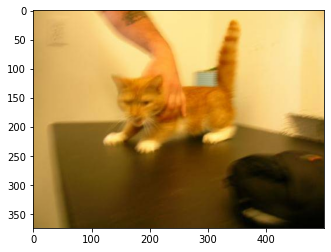

In [5]:
single_cat_image = plt.imread('train\\train\\'+list_tr_files[0])
plt.imshow(single_cat_image)
plt.show()

In [6]:
print('Shape of Single Cat Image: {}'.format(single_cat_image.shape))

Shape of Single Cat Image: (374, 500, 3)


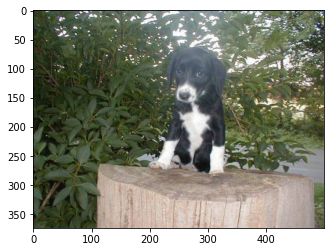

In [7]:
single_dog_image = plt.imread('train\\train\\'+list_tr_files[24230])
plt.imshow(single_dog_image)
plt.show()

In [8]:
print('Shape of Single dog Image: {}'.format(single_dog_image.shape))

Shape of Single dog Image: (374, 500, 3)


#### 3.2 Reading Image data and extracting label

In [9]:
def read_image_data(file_dir):
    y =[] # store the image label in the list "y" if it is cat then 0 else 1
    list_file_name = os.listdir(file_dir)
    for file in list_file_name:
        if file.split('.')[0]=='dog':
            y.append(1)
        else:
            y.append(0)
    return list_file_name,y

In [10]:
tr_path = 'train\\train\\'
te_path = 'test1\\test1\\'

In [11]:
x_tr,y_tr= read_image_data(tr_path)
x_te,y_te= read_image_data(te_path)
data_dict = {'fileName':x_tr,'label':y_tr}

In [12]:
#let's create a dataframe with filenames and their corresponding labels.
tr_df = pd.DataFrame(data=data_dict)

In [13]:
tr_df['Category'] = tr_df['label'].apply(lambda x: "cat" if x == 0 else "dog")

In [14]:
tr_df.head()

,fileName,label,Category
0,cat.0.jpg,0,cat
1,cat.1.jpg,0,cat
2,cat.10.jpg,0,cat
3,cat.100.jpg,0,cat
4,cat.1000.jpg,0,cat


In [15]:
tr_df.tail()

,fileName,label,Category
24995,dog.9995.jpg,1,dog
24996,dog.9996.jpg,1,dog
24997,dog.9997.jpg,1,dog
24998,dog.9998.jpg,1,dog
24999,dog.9999.jpg,1,dog


#### 3.3 Image size are of  different or same shape?

In [16]:
#shape of all the image
#s = plt.imread(tr_path+x_tr[0])
dim1 = [] # to store the array value of the width of the image
dim2 = [] # to store the array value of the length of the image

for file_name_img in x_tr:
    #print(file_name_img)
    img = plt.imread(tr_path+file_name_img)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

#### 3.3.1 Univariant analysis of dimension1 (width)

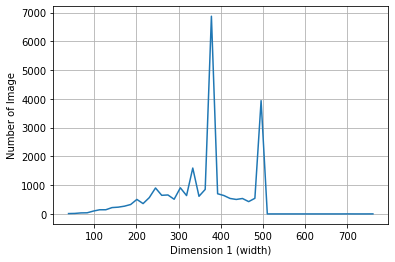

In [17]:
width_hist,width_bins = np.histogram(dim1,bins=50)
width_bin_cntrs = (width_bins[1:]+width_bins[:-1])*0.5
plt.plot(width_bin_cntrs, width_hist)
plt.xlabel('Dimension 1 (width)')
plt.ylabel('Number of Image')
plt.grid()
plt.show()

- __Observations:__
    - __Width of all of the images lies between 120 to 510.__
    - __Most of the image width lies between 300 to 500.__

#### 3.3.2 Univariant analysis of dimension2 (height)

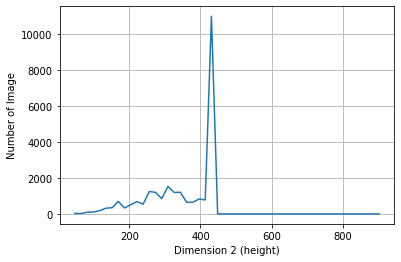

In [18]:
height_hist,height_bins = np.histogram(dim2,bins=50)
height_bin_cntrs = (height_bins[1:]+width_bins[:-1])*0.5
plt.plot(height_bin_cntrs, height_hist)
plt.xlabel('Dimension 2 (height)')
plt.ylabel('Number of Image')
plt.grid()
plt.show()

- __Observations:__
    - __Height of all of the images lies between 160 to 420.__
    - __Most of the image height lies between 200 to 410.__

#### 3.3.3 Analysis of dimension1 (width) and dimension 2(Height) of each image

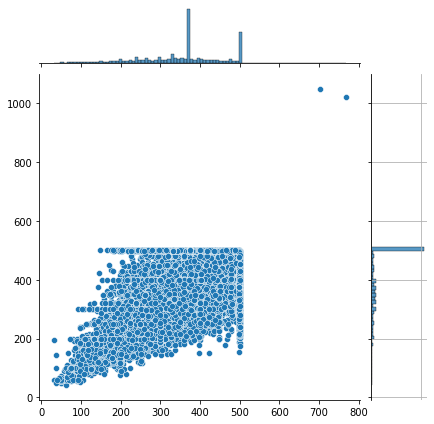

In [19]:
# Plot histogram to check the shape of each image
sns.jointplot(x= dim1,y =dim2)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid()
plt.show()

- __Observations:__
    - __From the above visualization, could see that all the image size are not the same shape.__
    - __All the images are of size between dim1 (50 to 500) and dim2(500 to 500).__
    - __There are two outliers, whose sizes are almost (700,1050) and (750,1000) respectively.__

In [20]:
Category = tr_df['Category'].tolist()

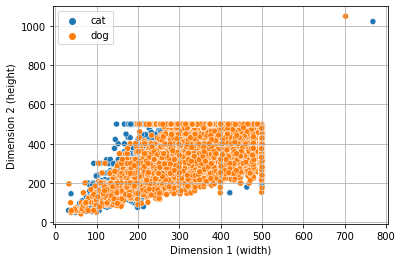

In [21]:
sns.scatterplot(x= dim1,y= dim2,hue = Category )
plt.xlabel('Dimension 1 (width)')
plt.ylabel('Dimension 2 (height)')
plt.grid()
plt.show()

- __Observation:__
    - __Blue Color: denotes the cats.__
    - __Orange Color: denotes the dogs.__
    - __There is one cat and one dog image, whose shapes are greater than 750 (dim1) and 1000(dim2).__
    - __So,both it is consderd as an outliers and vice versa with smaller image__

In [22]:
#average shape of image
print("Avergae shape of an image: ({},{},{})".format(np.mean(dim1),np.mean(dim2),colors))

Avergae shape of an image: (360.47808,404.09904,3)


- __Summary:__
    - __The images are not of the same shape.__
    - __We could see, few of the images are very small as compared the others (i.e.,with respect to average shape of the image).__
    - __So need to perform the following to make it of same shape:__
        - __if it is smaller pic then perform padding.__
        - __if it is larger pic then perform crop or shrink.__

#### 3.3.4 Feature Engineering (Data Augmentation)

- __Crop an Image__

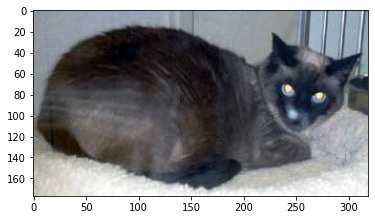

In [23]:
#original image
img_10 = plt.imread(tr_path+x_tr[10])
plt.imshow(img_10)
plt.show()

In [24]:
import tensorflow as tf
img_10 = plt.imread(tr_path+x_tr[10])
cropped = tf.image.central_crop(img_10, central_fraction=0.55)

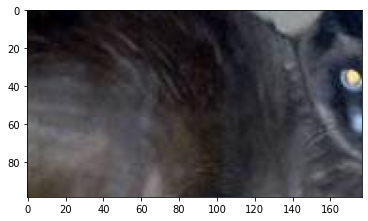

In [25]:
#let's see the cropped image
plt.imshow(cropped)

- __Flip an Image__

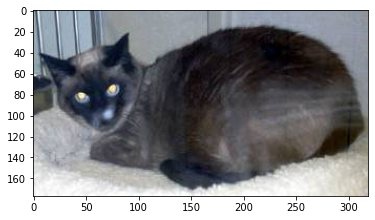

In [26]:
#flip an Image --- left and right
flip_img_10 = tf.image.flip_left_right(img_10)
plt.imshow(flip_img_10)

- __Grayscale an image__

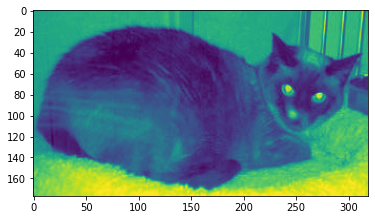

In [27]:
gray_scale_img_10 = tf.image.rgb_to_grayscale(img_10)
plt.imshow(gray_scale_img_10)
plt.show()

- __Rotate an Image__

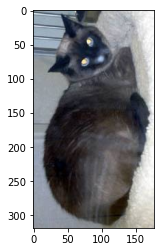

In [28]:
rotate_img_10 = tf.image.rot90(img_10)
plt.imshow(rotate_img_10)
plt.show()

- __Changes Image Brightness__

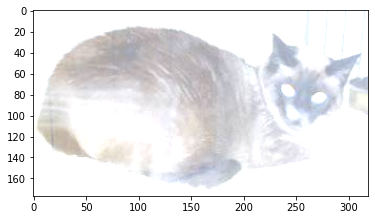

In [29]:
bright_img_10 = tf.image.adjust_brightness(img_10, 0.65)
plt.imshow(bright_img_10)
plt.show()

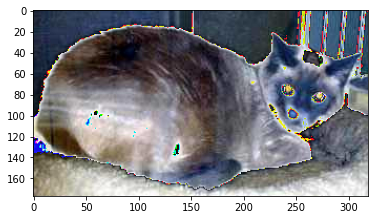

In [30]:
#After modifying the original image -  blurring the image
mod_img_10 = img_10*2
plt.imshow(mod_img_10)
plt.show()

In [31]:
sample_path = 'C:\\Data\\dogs-vs-cats\\Sample Augmented data\\'
sample_path

'C:\\Data\\dogs-vs-cats\\Sample Augmented data\\'

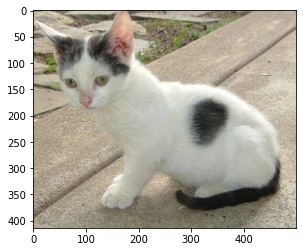

In [32]:
#let's take an example of another (original) image with all the augmentation technique:
img_4 = plt.imread(sample_path +'cat.3.jpg')
plt.imshow(img_4)
plt.show()

In [33]:
img_4.shape

(414, 500, 3)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
data_aug_img_4 = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest'
                                   )

In [35]:
data_aug_img_4

In [36]:
img_4_pil = load_img(sample_path+'cat.3.jpg')

In [37]:
#convert the PIL image to numpy array
img_4_array = img_to_array(img_4_pil)

In [38]:
#shape of pil image array i.e this is a numpy array of size (414,500,3)
img_4_array.shape

(414, 500, 3)

In [39]:
img_4_array = img_4_array.reshape((1,) + img_4_array.shape)

In [40]:
img_4_array.shape

(1, 414, 500, 3)

In [41]:
pwd

'C:\\Data\\dogs-vs-cats'

In [43]:
#generating the 10 sample of the above image after agumentation
num_sample=0
for batch in data_aug_img_4.flow(img_4_array,
                                batch_size=1,
                                save_to_dir='Sample Augmented data',
                                save_prefix='cat',
                                save_format='jpg'):
    num_sample+=1
    #create 10 sample of the image
    if num_sample>10:
        break 

In [47]:
list_augmented_sample_image = os.listdir(path=sample_path)
len(list_augmented_sample_image)

10

In [48]:
list_augmented_sample_image[0]

'cat.3.jpg'

In [51]:
for aug_img in list_augmented_sample_image:
    print(aug_img)

cat.3.jpg
cat_0_1154.jpg
cat_0_2243.jpg
cat_0_5025.jpg
cat_0_5309.jpg
cat_0_656.jpg
cat_0_7058.jpg
cat_0_7442.jpg
cat_0_9071.jpg
cat_0_9259.jpg


In [53]:
sample_path

'C:\\Data\\dogs-vs-cats\\Sample Augmented data\\'

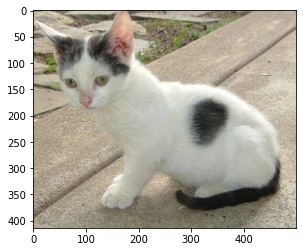

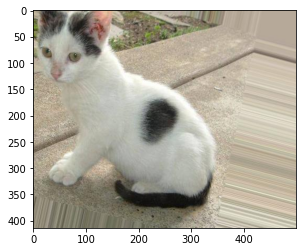

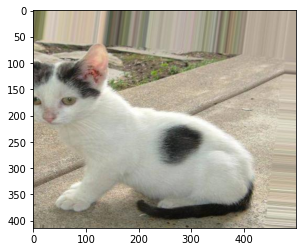

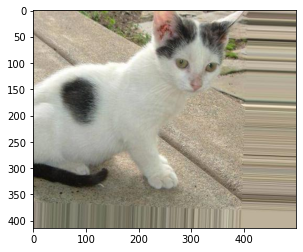

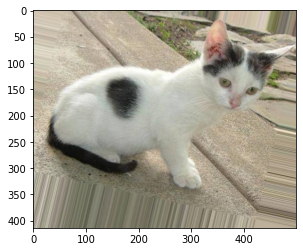

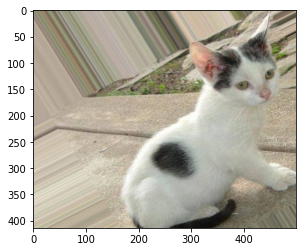

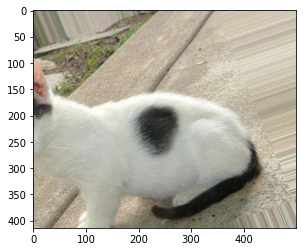

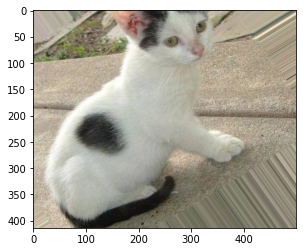

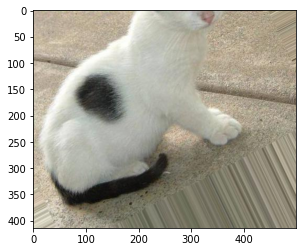

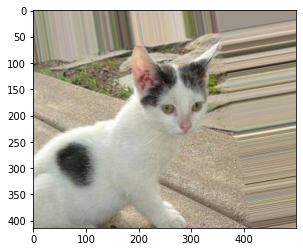

In [54]:
#load the augmented image and display
#plt.figure(figsize=(10,10))
#for i in range(10):
 #   ax = plt.subplot(3,3,i+1)
for indx,aug_img in enumerate(list_augmented_sample_image):
    img_arr = plt.imread(sample_path+aug_img)
    plt.imshow(img_arr)
    plt.show()
    
        

In [59]:
for indx,aug_img in enumerate(list_augmented_sample_image):
    print(indx,aug_img)

0 cat.3.jpg
1 cat_0_1154.jpg
2 cat_0_2243.jpg
3 cat_0_5025.jpg
4 cat_0_5309.jpg
5 cat_0_656.jpg
6 cat_0_7058.jpg
7 cat_0_7442.jpg
8 cat_0_9071.jpg
9 cat_0_9259.jpg


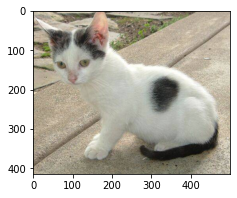

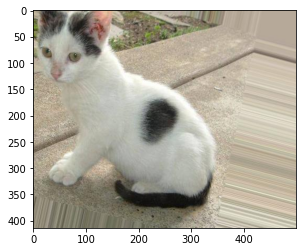

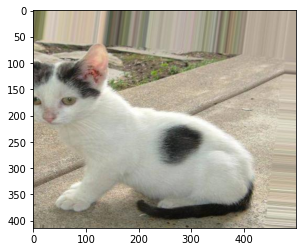

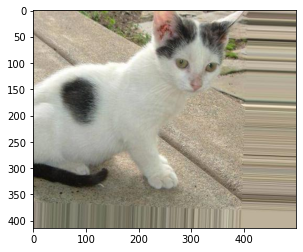

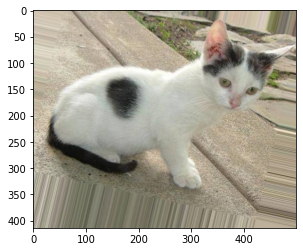

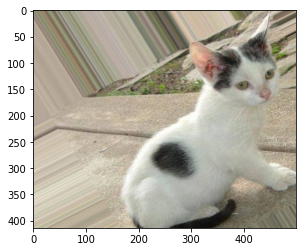

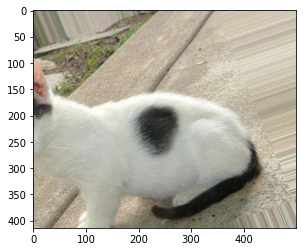

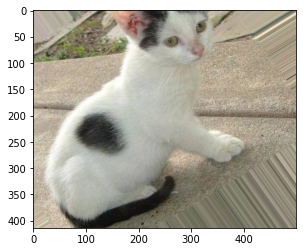

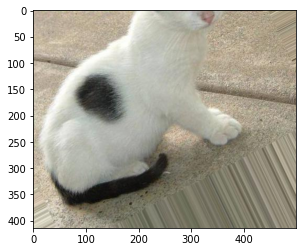

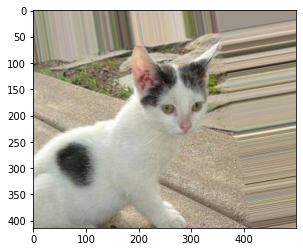

In [62]:
plt.figure(figsize=(4,3))
for aug_img in (list_augmented_sample_image):
    img_arr = plt.imread(sample_path+aug_img)
    plt.imshow(img_arr)
    plt.show()